<a href="https://colab.research.google.com/github/oykudemirel/DSA-210-PROJECT/blob/main/dsa210project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Get the tmdb list which has all the movies

import requests
import time
import pandas as pd

API_KEY = '823fecbf63a8e7692fe9329ead448aac'
base_url = "https://api.themoviedb.org/3/discover/movie"

all_movies = []

for year in range(2016, 2021):
    print(f"Processing year: {year}")
    page = 1

    while True:
        params = {
    "api_key": API_KEY,
    "primary_release_year": year,
    "sort_by": "popularity.desc",  # Sort results so we get the most relevant
    "vote_count.gte": 10,          # Only include movies with at least 10 votes
    "page": page
}


        response = requests.get(base_url, params=params)
        data = response.json()

        if 'results' not in data or len(data['results']) == 0:
            print("No results, stopping...")
            break

        for movie in data['results']:
            title = movie.get('title', '')
            release_date = movie.get('release_date', '')

            if release_date:
                year_part = int(release_date.split('-')[0])
                month_part = int(release_date.split('-')[1])
            else:
                year_part = year
                month_part = None

            all_movies.append({
                "Title": title,
                "Release Year": year_part,
                "Release Month": month_part,
                "Release Date": release_date
            })

        if page >= data.get('total_pages', 1):
            break
        page += 1
        time.sleep(0.3)

# Save to CSV
df = pd.DataFrame(all_movies)
df.to_csv("tmdb_movies_2016_2020.csv", index=False)
print(df.head())



Processing year: 2016
Processing year: 2017
Processing year: 2018
Processing year: 2019
Processing year: 2020
                                Title  Release Year  Release Month  \
0  Batman v Superman: Dawn of Justice          2016              3   
1               The Girl on the Train          2016             10   
2              Underworld: Blood Wars          2016             11   
3                      The Accountant          2016             10   
4                           Moonlight          2016             10   

  Release Date  
0   2016-03-23  
1   2016-10-05  
2   2016-11-24  
3   2016-10-13  
4   2016-10-21  


In [3]:
# Categorize the seasons
def categorize_season(month):
    if month in [11, 12]:
        return 'Holiday Season'
    elif month in [1, 2, 9, 10]:
        return 'Awards Season'
    elif month in [6, 7, 8]:
        return 'Summer Blockbuster'
    elif month in [3, 4, 5]:
        return 'Spring'
    else:
        return 'Other'  # For missing or weird months

df['Release Season'] = df['Release Month'].apply(categorize_season)


print(df[['Title', 'Release Year', 'Release Month', 'Release Season']].head())


                                Title  Release Year  Release Month  \
0  Batman v Superman: Dawn of Justice          2016              3   
1               The Girl on the Train          2016             10   
2              Underworld: Blood Wars          2016             11   
3                      The Accountant          2016             10   
4                           Moonlight          2016             10   

   Release Season  
0          Spring  
1   Awards Season  
2  Holiday Season  
3   Awards Season  
4   Awards Season  


Release Season
Awards Season         6061
Spring                3654
Summer Blockbuster    3426
Holiday Season        2858
Name: count, dtype: int64


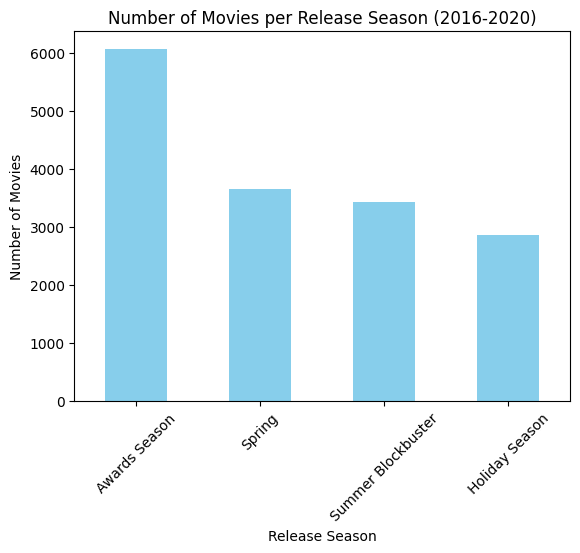

In [4]:
# Movies per Release Season
season_counts = df['Release Season'].value_counts()
print(season_counts)


import matplotlib.pyplot as plt

season_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Movies per Release Season (2016-2020)')
plt.ylabel('Number of Movies')
plt.xlabel('Release Season')
plt.xticks(rotation=45)
plt.show()


In [5]:
#Web scraped the website Box Office Mojo to get the box office numbers
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

pd.set_option('display.float_format', '{:.0f}'.format)

years = list(range(2016, 2021))

base_url = "https://www.boxofficemojo.com/year/world/{year}/"


all_data = []

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

for year in years:
    print(f"Processing year: {year}")
    url = base_url.format(year=year)
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Failed to retrieve data for {year}: {e}")
        continue

    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table containing the box office data
    table = soup.find('table')
    if not table:
        print(f"No table found for {year}")
        continue

    # Extract table rows, skip header row,
    rows = table.find_all('tr')[1:]

    for row in rows:
        cols = row.find_all('td')
        if len(cols) < 3:
            continue  # Skip rows that don't have enough columns
        release_group = cols[1].get_text(strip=True)
        worldwide_gross = cols[2].get_text(strip=True)
        all_data.append({
            'Year': year,
            'Release Group': release_group,
            'Worldwide Gross': worldwide_gross
        })


    time.sleep(1)


df_box_office = pd.DataFrame(all_data)



# Remove dollar signs and commas and convert to numeric
df_box_office['Worldwide Gross'] = df_box_office['Worldwide Gross'].replace('[\$,]', '', regex=True).astype(float)


print(df_box_office.head())


Processing year: 2016
Processing year: 2017
Processing year: 2018
Processing year: 2019
Processing year: 2020
   Year                 Release Group  Worldwide Gross
0  2016    Captain America: Civil War       1153296293
1  2016  Rogue One: A Star Wars Story       1056057273
2  2016                  Finding Dory       1028570889
3  2016                      Zootopia       1023784195
4  2016               The Jungle Book        966550600


In [6]:
# Normalize titles
def normalize_title(title):
    if pd.isnull(title):
        return ""
    return title.lower().strip()


df['normalized_title'] = df['Title'].apply(normalize_title)
df_box_office['normalized_title'] = df_box_office['Release Group'].apply(normalize_title)

# Merge on normalized titles and year
merged_df = pd.merge(
    df,
    df_box_office,
    left_on=['normalized_title', 'Release Year'],
    right_on=['normalized_title', 'Year'],
    how='left'
)

# Now fix the _x and _y
def clean_merge_columns(df, prefer='_x'):
    """Fix columns after merge that have _x and _y versions."""
    for col in df.columns:
        if col.endswith(prefer):
            base = col[:-2]  # remove _x or _y
            other = base + ('_y' if prefer == '_x' else '_x')
            if other in df.columns:
                df = df.drop(columns=[other])
            df = df.rename(columns={col: base})
    return df

merged_df = clean_merge_columns(merged_df)

merged_df.drop(columns=['normalized_title', 'Year'], errors='ignore', inplace=True)

print(merged_df[['Title', 'Release Year', 'Release Month', 'Release Season', 'Worldwide Gross']].head())


                                Title  Release Year  Release Month  \
0  Batman v Superman: Dawn of Justice          2016              3   
1               The Girl on the Train          2016             10   
2              Underworld: Blood Wars          2016             11   
3                      The Accountant          2016             10   
4                           Moonlight          2016             10   

   Release Season  Worldwide Gross  
0          Spring        874360194  
1   Awards Season        173185859  
2  Holiday Season         81093313  
3   Awards Season        155560045  
4   Awards Season         65172611  


In [7]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"oykudemirell","key":"b41ccc22de14a9a86f326e961286b890"}'}

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [9]:
!kaggle datasets download -d unanimad/bafta-awards

!unzip -o bafta-awards.zip
!ls

Dataset URL: https://www.kaggle.com/datasets/unanimad/bafta-awards
License(s): CC0-1.0
Archive:  bafta-awards.zip
  inflating: bafta_films.csv         
bafta-awards.zip  kaggle.json  tmdb_movies_2016_2020.csv
bafta_films.csv   sample_data


In [10]:
#BAFTA Awards
import pandas as pd

df_b = pd.read_csv('bafta_films.csv')


df_b['year'] = pd.to_numeric(df_b['year'], errors='coerce')

df_b = df_b[(df_b['year'] >= 2016) & (df_b['year'] <= 2020)]

#Drop unnecessary columns
df_b = df_b.drop(columns=['category', 'workers'])

df_b.head()


,year,nominee,winner
3575,2016,The Big Short,True
3576,2016,Brooklyn,False
3577,2016,Carol,False
3578,2016,Room,False
3579,2016,Steve Jobs,False


In [11]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"oykudemirell","key":"ebf90736d0540d12a0d387475a61f434"}'}

In [12]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp "kaggle (1).json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [13]:
!kaggle datasets download -d unanimad/golden-globe-awards
!unzip -o golden-globe-awards.zip
!ls


Dataset URL: https://www.kaggle.com/datasets/unanimad/golden-globe-awards
License(s): CC0-1.0
Archive:  golden-globe-awards.zip
  inflating: golden_globe_awards.csv  
 bafta-awards.zip	   golden-globe-awards.zip   sample_data
 bafta_films.csv	  'kaggle (1).json'	     tmdb_movies_2016_2020.csv
 golden_globe_awards.csv   kaggle.json


In [14]:
#Golden Globe Awards
import pandas as pd


df_gg = pd.read_csv('golden_globe_awards.csv')

# Filter by year and drop unnecessary columns
df_gg['year_film'] = pd.to_numeric(df_gg['year_film'], errors='coerce')
df_gg = df_gg[(df_gg['year_film'] >= 2016) & (df_gg['year_film'] <= 2020)]

df_gg = df_gg.dropna(subset=['film'])

df_gg = df_gg.drop(columns=['year_award', 'ceremony', 'category', 'nominee'])


df_gg.head()


,year_film,film,win
7494,2016,Elle,True
7495,2016,Arrival,False
7496,2016,Miss Sloane,False
7497,2016,Loving,False
7498,2016,Jackie,False


In [15]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"oykudemirell","key":"24fc20083ed3bb7604f8159dd18baa8c"}'}

In [16]:
!mkdir -p ~/.kaggle
!cp "kaggle (2).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle


In [17]:
!kaggle datasets download -d unanimad/the-oscar-award
!unzip -o the-oscar-award.zip
!ls


Dataset URL: https://www.kaggle.com/datasets/unanimad/the-oscar-award
License(s): CC0-1.0
Archive:  the-oscar-award.zip
  inflating: full_data.csv           
  inflating: the_oscar_award.csv     
 bafta-awards.zip	   golden-globe-awards.zip   sample_data
 bafta_films.csv	  'kaggle (1).json'	     the_oscar_award.csv
 full_data.csv		  'kaggle (2).json'	     the-oscar-award.zip
 golden_globe_awards.csv   kaggle.json		     tmdb_movies_2016_2020.csv


In [18]:
#Oscar Awards
import pandas as pd

df_oscar = pd.read_csv('the_oscar_award.csv')

df_oscar = df_oscar.drop(columns=['year_ceremony', 'ceremony', 'category', 'canon_category', 'name'], errors='ignore')


df_oscar = df_oscar[(df_oscar['year_film'] >= 2016) & (df_oscar['year_film'] <= 2020)]

df_oscar.head()


,year_film,film,winner
9984,2016,Manchester by the Sea,True
9985,2016,Hacksaw Ridge,False
9986,2016,La La Land,False
9987,2016,Captain Fantastic,False
9988,2016,Fences,False


In [19]:
print(df_oscar.columns)
print(df_gg.columns)
print(df_b.columns)


Index(['year_film', 'film', 'winner'], dtype='object')
Index(['year_film', 'film', 'win'], dtype='object')
Index(['year', 'nominee', 'winner'], dtype='object')


In [20]:
# Standardize columns

# Oscars
df_oscar = df_oscar.rename(columns={
    'film': 'Title',
    'year_film': 'Release Year'
})

# Golden Globes
df_gg = df_gg.rename(columns={
    'film': 'Title',
    'year_film': 'Release Year'
})

# BAFTA
df_b = df_b.rename(columns={
    'nominee': 'Title',
    'year': 'Release Year'
})



In [61]:
# Drop duplicates
df_oscar = df_oscar.drop_duplicates(subset='normalized_title')
df_gg = df_gg.drop_duplicates(subset='normalized_title')
df_b = df_b.drop_duplicates(subset='normalized_title')


merged_df2 = df_oscar.copy()

# Merge with Golden Globes
merged_df2 = merged_df2.merge(df_gg[['normalized_title', 'GG_Win']], on='normalized_title', how='left')

# Merge with BAFTA
merged_df2 = merged_df2.merge(df_b[['normalized_title', 'BAFTA_Win']], on='normalized_title', how='left')

# Fill missing wins with 0 and make sure they are integers
merged_df2[['Oscar_Win', 'GG_Win', 'BAFTA_Win']] = merged_df2[['Oscar_Win', 'GG_Win', 'BAFTA_Win']].fillna(0).astype(int)

# Create a total awards won column
merged_df2['Total_Awards_Won'] = merged_df2[['Oscar_Win', 'GG_Win', 'BAFTA_Win']].sum(axis=1)


print(merged_df2[['Title', 'Release Year', 'Oscar_Win', 'GG_Win', 'BAFTA_Win', 'Total_Awards_Won']].head())


                   Title  Release Year  Oscar_Win  GG_Win  BAFTA_Win  \
0  Manchester by the Sea          2016          1       1          1   
1          Hacksaw Ridge          2016          1       1          1   
2             La La Land          2016          1       1          1   
3      Captain Fantastic          2016          1       1          0   
4                 Fences          2016          1       1          0   

   Total_Awards_Won  
0                 3  
1                 3  
2                 3  
3                 2  
4                 2  


In [24]:

def normalize_title(title):
    if pd.isna(title):
        return ''
    return title.lower().strip()

df_oscar['normalized_title'] = df_oscar['Title'].apply(normalize_title)
df_gg['normalized_title'] = df_gg['Title'].apply(normalize_title)
df_b['normalized_title'] = df_b['Title'].apply(normalize_title)

#Count how many wins each movie had per award show
df_oscar_counts = df_oscar.groupby('normalized_title').size().reset_index(name='Oscar_Win')
df_gg_counts = df_gg.groupby('normalized_title').size().reset_index(name='GG_Win')
df_b_counts = df_b.groupby('normalized_title').size().reset_index(name='BAFTA_Win')

#Merge
merged_df2 = df_oscar_counts.merge(df_gg_counts, on='normalized_title', how='outer')
merged_df2 = merged_df2.merge(df_b_counts, on='normalized_title', how='outer')

#Fill missing values with 0
merged_df2[['Oscar_Win', 'GG_Win', 'BAFTA_Win']] = merged_df2[['Oscar_Win', 'GG_Win', 'BAFTA_Win']].fillna(0).astype(int)

#Calculate the total number of awards won
merged_df2['Total_Awards_Won'] = merged_df2[['Oscar_Win', 'GG_Win', 'BAFTA_Win']].sum(axis=1)


merged_df2 = merged_df2.merge(df_oscar[['normalized_title', 'Title', 'Release Year']], on='normalized_title', how='left')


merged_df2 = merged_df2.dropna(subset=['Title']).reset_index(drop=True)

print(merged_df2[['Title', 'Release Year', 'Oscar_Win', 'GG_Win', 'BAFTA_Win', 'Total_Awards_Won']].head())


                                       Title  Release Year  Oscar_Win  GG_Win  \
0  13 Hours: The Secret Soldiers of Benghazi          2016          1       0   
1                                       13th          2016          1       0   
2                                       1917          2019         10       2   
3                                       1917          2019         10       2   
4                                       1917          2019         10       2   

   BAFTA_Win  Total_Awards_Won  
0          0                 1  
1          1                 2  
2          9                21  
3          9                21  
4          9                21  
✅ All award counts are correctly matched!


In [25]:
print(merged_df2.columns)


Index(['normalized_title', 'Oscar_Win', 'GG_Win', 'BAFTA_Win',
       'Total_Awards_Won', 'Title', 'Release Year'],
      dtype='object')


In [26]:
print(merged_df.columns)


Index(['Title', 'Release Year', 'Release Month', 'Release Date',
       'Release Season', 'Release Group', 'Worldwide Gross'],
      dtype='object')


In [27]:
# Merge the clean movies/box office data (merged_df) with awards data (merged_df2)
final_df = pd.merge(
    merged_df,
    merged_df2[['Title', 'Release Year', 'Oscar_Win', 'GG_Win', 'BAFTA_Win', 'Total_Awards_Won']],
    on=['Title', 'Release Year'],
    how='left'
)

print(final_df.head())


                                Title  Release Year  Release Month  \
0  Batman v Superman: Dawn of Justice          2016              3   
1               The Girl on the Train          2016             10   
2              Underworld: Blood Wars          2016             11   
3                      The Accountant          2016             10   
4                           Moonlight          2016             10   

  Release Date  Release Season                       Release Group  \
0   2016-03-23          Spring  Batman v Superman: Dawn of Justice   
1   2016-10-05   Awards Season               The Girl on the Train   
2   2016-11-24  Holiday Season              Underworld: Blood Wars   
3   2016-10-13   Awards Season                      The Accountant   
4   2016-10-21   Awards Season                           Moonlight   

   Worldwide Gross  Oscar_Win  GG_Win  BAFTA_Win  Total_Awards_Won  
0        874360194        NaN     NaN        NaN               NaN  
1        173185859  

In [30]:
# Fill NaN award counts with 0
award_cols = ['Oscar_Win', 'GG_Win', 'BAFTA_Win', 'Total_Awards_Won']
final_df[award_cols] = final_df[award_cols].fillna(0).astype(int)


final_df = final_df.drop(columns=['Release Group'])

print(final_df.head())


                                Title  Release Year  Release Month  \
0  Batman v Superman: Dawn of Justice          2016              3   
1               The Girl on the Train          2016             10   
2              Underworld: Blood Wars          2016             11   
3                      The Accountant          2016             10   
4                           Moonlight          2016             10   

  Release Date  Release Season  Worldwide Gross  Oscar_Win  GG_Win  BAFTA_Win  \
0   2016-03-23          Spring        874360194          0       0          0   
1   2016-10-05   Awards Season        173185859          0       0          0   
2   2016-11-24  Holiday Season         81093313          0       0          0   
3   2016-10-13   Awards Season        155560045          0       0          0   
4   2016-10-21   Awards Season         65172611          8       5          2   

   Total_Awards_Won  
0                 0  
1                 0  
2                 0  
3   

In [31]:
print(final_df.columns)



Index(['Title', 'Release Year', 'Release Month', 'Release Date',
       'Release Season', 'Worldwide Gross', 'Oscar_Win', 'GG_Win', 'BAFTA_Win',
       'Total_Awards_Won'],
      dtype='object')


Exploratory Data Analysis and Hypothesis Testing

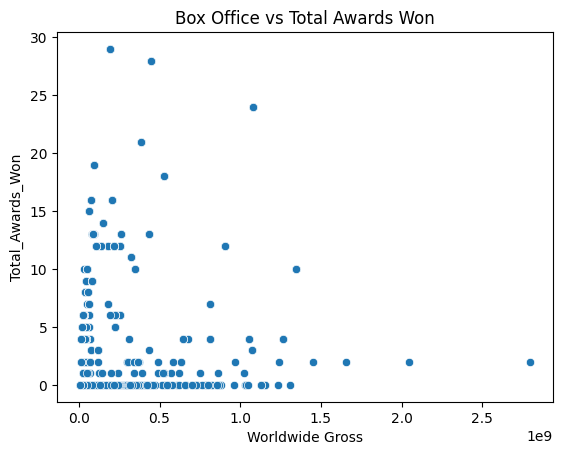

In [34]:
import seaborn as sns
sns.scatterplot(x='Worldwide Gross', y='Total_Awards_Won', data=final_df)
plt.title('Box Office vs Total Awards Won')
plt.show()
#Is there a relationship between Worldwide Gross and Total Awards Won?

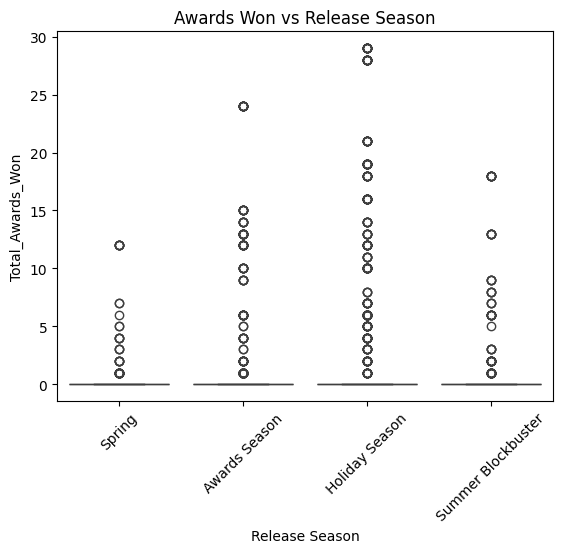

In [35]:
sns.boxplot(x='Release Season', y='Total_Awards_Won', data=final_df)
plt.title('Awards Won vs Release Season')
plt.xticks(rotation=45)
plt.show()
#Do movies released in the "Awards Season" win more awards?

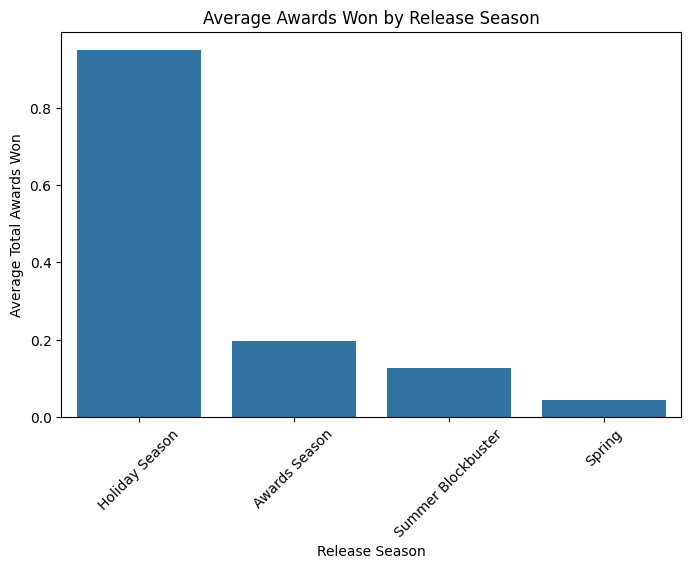

In [37]:

season_awards = final_df.groupby('Release Season')['Total_Awards_Won'].mean().sort_values(ascending=False)


plt.figure(figsize=(8,5))
sns.barplot(x=season_awards.index, y=season_awards.values)
plt.title('Average Awards Won by Release Season')
plt.xlabel('Release Season')
plt.ylabel('Average Total Awards Won')
plt.xticks(rotation=45)
plt.show()


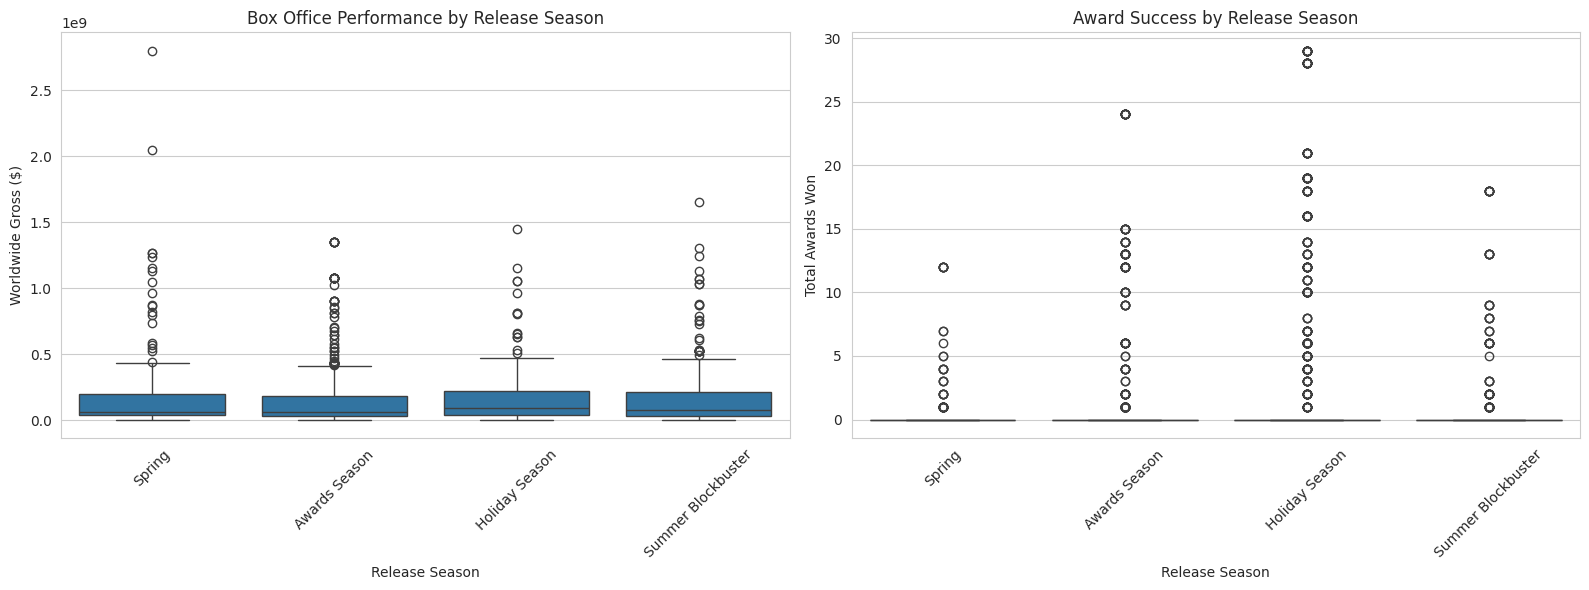

In [38]:

sns.set_style('whitegrid')


fig, axes = plt.subplots(1, 2, figsize=(16,6))

# Plot 1: Box Office performance by Release Season
sns.boxplot(x='Release Season', y='Worldwide Gross', data=final_df, ax=axes[0])
axes[0].set_title('Box Office Performance by Release Season')
axes[0].set_ylabel('Worldwide Gross ($)')
axes[0].set_xlabel('Release Season')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Award success by Release Season
sns.boxplot(x='Release Season', y='Total_Awards_Won', data=final_df, ax=axes[1])
axes[1].set_title('Award Success by Release Season')
axes[1].set_ylabel('Total Awards Won')
axes[1].set_xlabel('Release Season')
axes[1].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()


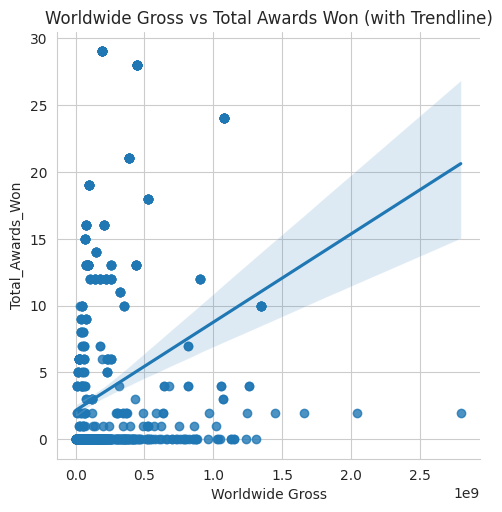

In [41]:
sns.lmplot(x='Worldwide Gross', y='Total_Awards_Won', data=final_df)
plt.title('Worldwide Gross vs Total Awards Won (with Trendline)')
plt.show()


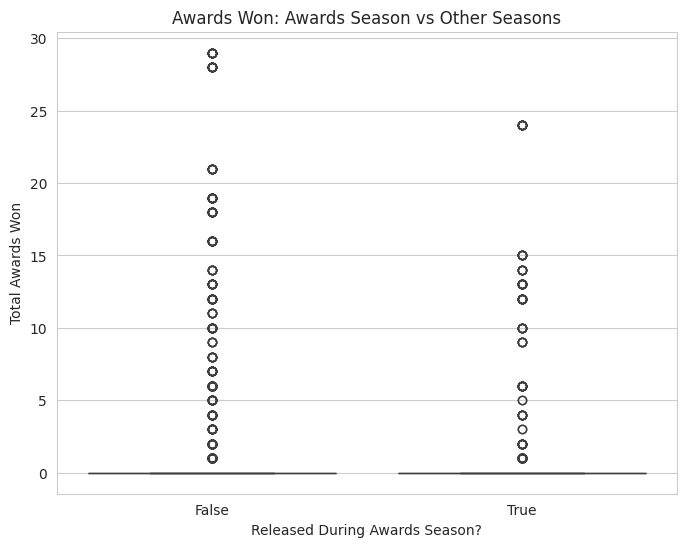

Is_Awards_Season
False   0
True    0
Name: Total_Awards_Won, dtype: float64


In [43]:
#Does releasing during awards season increase chances of winning awards?
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new column for "Awards Season?" (Yes/No)
final_df['Is_Awards_Season'] = final_df['Release Season'] == 'Awards Season'

# Boxplot to compare
plt.figure(figsize=(8,6))
sns.boxplot(x='Is_Awards_Season', y='Total_Awards_Won', data=final_df)
plt.title('Awards Won: Awards Season vs Other Seasons')
plt.xlabel('Released During Awards Season?')
plt.ylabel('Total Awards Won')
plt.show()

# Also calculate the mean awards won for both groups
mean_awards = final_df.groupby('Is_Awards_Season')['Total_Awards_Won'].mean()
print(mean_awards)


In [1]:
from scipy.stats import ttest_ind
# Split the data
awards_season = final_df[final_df['Is_Awards_Season']]['Total_Awards_Won']
non_awards_season = final_df[~final_df['Is_Awards_Season']]['Total_Awards_Won']

# Perform an independent t-test
t_stat, p_value = ttest_ind(awards_season, non_awards_season, equal_var=False)  # Welch's t-test (safer if variances are different)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")


NameError: name 'final_df' is not defined

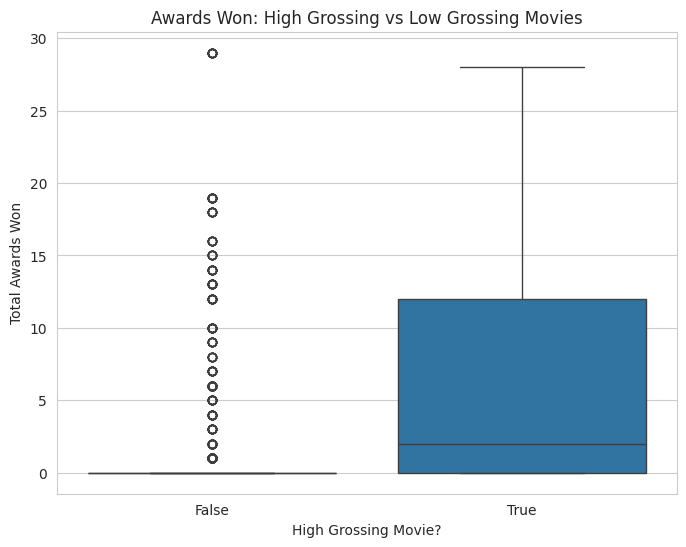

Is_High_Gross
False   0
True    7
Name: Total_Awards_Won, dtype: float64


In [44]:
#Do high-grossing movies have better chances of winning awards, regardless of release timing?

threshold = final_df['Worldwide Gross'].quantile(0.75)

final_df['Is_High_Gross'] = final_df['Worldwide Gross'] >= threshold

# Boxplot to compare
plt.figure(figsize=(8,6))
sns.boxplot(x='Is_High_Gross', y='Total_Awards_Won', data=final_df)
plt.title('Awards Won: High Grossing vs Low Grossing Movies')
plt.xlabel('High Grossing Movie?')
plt.ylabel('Total Awards Won')
plt.show()


mean_awards_gross = final_df.groupby('Is_High_Gross')['Total_Awards_Won'].mean()
print(mean_awards_gross)


#High box office success is correlated with winning more awards.
#High-grossing movies tend to win more awards regardless of release season.


In [45]:
# Check basic statistics and how many movies won 0 awards
print(final_df['Total_Awards_Won'].describe())

zero_awards = (final_df['Total_Awards_Won'] == 0).sum()
print(f"Movies with 0 awards: {zero_awards} out of {len(final_df)}")


count   16294
mean        0
std         2
min         0
25%         0
50%         0
75%         0
max        29
Name: Total_Awards_Won, dtype: float64
Movies with 0 awards: 15759 out of 16294


In [46]:
from scipy.stats import ttest_ind

# Separate groups
high_gross_awards = final_df[final_df['Is_High_Gross'] == True]['Total_Awards_Won']
low_gross_awards = final_df[final_df['Is_High_Gross'] == False]['Total_Awards_Won']

# Perform t-test
t_stat, p_value = ttest_ind(high_gross_awards, low_gross_awards, equal_var=False)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.5f}")


T-statistic: 12.482
P-value: 0.00000


Release Season
Holiday Season       1
Awards Season        0
Summer Blockbuster   0
Spring               0
Name: Total_Awards_Won, dtype: float64


<ipython-input-48-1dba417c3eb5>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=season_awards.index, y=season_awards.values, palette="viridis")


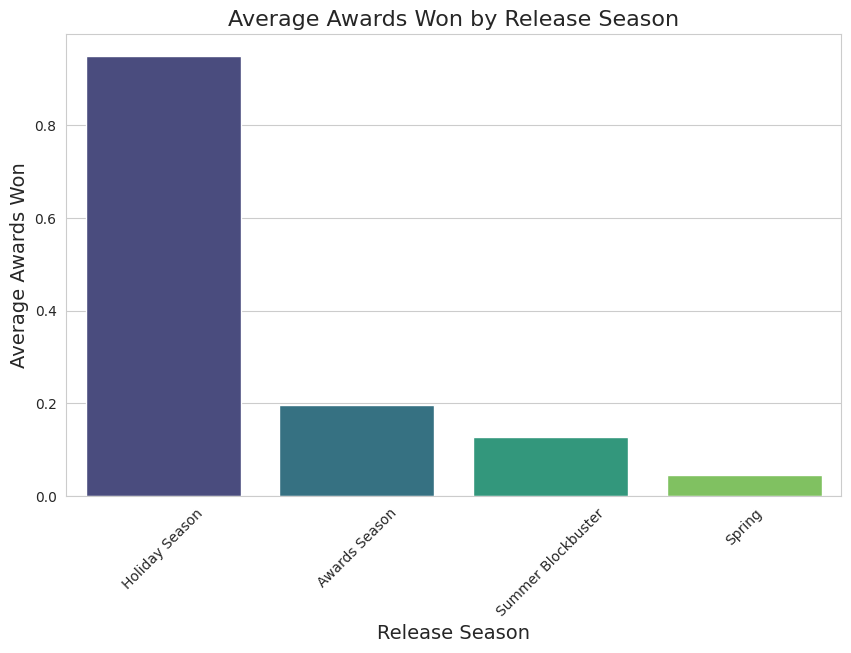

In [48]:
# Group by season and calculate the mean number of awards
season_awards = final_df.groupby('Release Season')['Total_Awards_Won'].mean().sort_values(ascending=False)


print(season_awards)

#Plot for better visualization
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(x=season_awards.index, y=season_awards.values, palette="viridis")
plt.title('Average Awards Won by Release Season', fontsize=16)
plt.xlabel('Release Season', fontsize=14)
plt.ylabel('Average Awards Won', fontsize=14)
plt.xticks(rotation=45)
plt.show()


In [50]:
from scipy.stats import f_oneway

# Separate the awards data by season
holiday_awards = final_df[final_df['Release Season'] == 'Holiday Season']['Total_Awards_Won']
awards_season_awards = final_df[final_df['Release Season'] == 'Awards Season']['Total_Awards_Won']
summer_awards = final_df[final_df['Release Season'] == 'Summer Blockbuster']['Total_Awards_Won']
spring_awards = final_df[final_df['Release Season'] == 'Spring']['Total_Awards_Won']

#One-way ANOVA
f_stat, p_value = f_oneway(holiday_awards, awards_season_awards, summer_awards, spring_awards)

print(f"F-statistic: {f_stat:.3f}")
print(f"P-value: {p_value:.5f}")


F-statistic: 131.126
P-value: 0.00000


In [55]:
print(final_df.columns)


Index(['Title', 'Release Year', 'Release Month', 'Release Date',
       'Release Season', 'Worldwide Gross', 'Oscar_Win', 'GG_Win', 'BAFTA_Win',
       'Total_Awards_Won', 'Is_Awards_Season', 'Is_High_Gross'],
      dtype='object')


In [60]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

anova_df = final_df[['Release Season', 'Is_High_Gross', 'Total_Awards_Won']].dropna().rename(columns={'Release Season': 'Release_Season'})


#Two-Way ANOVA


model = ols('Total_Awards_Won ~ C(Release_Season) + C(Is_High_Gross) + C(Release_Season):C(Is_High_Gross)', data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)



                                    sum_sq    df    F  PR(>F)
C(Release_Season)                     1340     3  131       0
C(Is_High_Gross)                     11191     1 3283       0
C(Release_Season):C(Is_High_Gross)    3025     3  296       0
Residual                             55508 16286  NaN     NaN
